# Visual Question Answering (VQA)
This notebook implements a multi-modal architecture for VQA based on the DAQUAR dataset introduced here: [DAQUAR dataset](https://www.mpi-inf.mpg.de/departments/computer-vision-and-machine-learning/research/vision-and-language/visual-turing-challenge/)

The objective of this project is to merge two modalities: Images + Text and build an AI that can answer questions about images.

In [2]:
# Imports

import os
import numpy as np
import torch
import torch.nn as nn

from PIL import Image
from datasets import load_dataset

from sklearn.metrics import accuracy_score, f1_score

# Set up device agnostic code

device = torch.device('cuda' if torch.cuda.is_available() else ('mps' if torch.mps.is_available() else 'cpu'))
print(f"Using device: {device}")

Using device: mps


## Dataset

The processed version of the dataset used in this project can be downloaded from Kaggle [here](https://www.kaggle.com/datasets/tezansahu/processed-daquar-dataset/data). Also contains the original dataset files.

### Original dataset
The original dataset has 3 files:
- `all_qa_pairs.txt`
- `train_images_list.txt`
- `test_images_list.txt`

### Processed dataset

The processed version dataset contains a processed version of the full DAQUAR dataset, with the following descriptions:
- `data.csv`: Processed dataset after normalizing all the questions and conversting the data into a tabular format {question, answer, image_id}
- `data_train.csv`: Training data from `train_images_list.txt`
- `data_eval.csv`: Testing data from `test_images_list.txt`
- `answer_space.txt`: List of all possible answers extracted from `all_qa_pairs.txt`

In [4]:
# Load the dataset
dataset = load_dataset(
    "csv",
    data_files={
        "train": os.path.join("..", "data", "data_train.csv"),
        "test": os.path.join("..", "data", "data_eval.csv")
    }
)

# print(dataset)

with open(os.path.join("..", "data", "answer_space.txt")) as f:
    answer_space = [line.strip() for line in f if line.strip()]

answer_space

# dataset = dataset.map(
#     lambda examples: {
#         'label': [
#             answer_space.index(ans.replace(" ", "").split(",")[0]) #Selects the first answer in case there are more than one
#             for ans in examples['answer']
#         ]
#     },
#     batched=True
# )

# print(dataset)

['1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '18',
 '19',
 '2',
 '2163',
 '22',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'air_conditioner',
 'air_vent',
 'alarm',
 'alarm_clock',
 'album',
 'aluminium_foil',
 'apple',
 'ashtray',
 'baby_chair',
 'baby_gate',
 'back_scrubber',
 'backpack',
 'bag',
 'ball',
 'balloon',
 'banana',
 'banister',
 'bar_of_soap',
 'basket',
 'basketball',
 'basketball_hoop',
 'bathtub',
 'bean_bag',
 'bed',
 'bed_sheets',
 'belt',
 'bench',
 'bicycle',
 'bicycle_helmet',
 'bin',
 'binder',
 'black',
 'blackboard',
 'blanket',
 'blender',
 'blinds',
 'blue',
 'board',
 'book',
 'book_holder',
 'bookrack',
 'books',
 'bookshelf',
 'bottle',
 'bottle_of_hand_wash_liquid',
 'bottle_of_liquid',
 'bottle_of_listerine',
 'bottle_of_perfume',
 'bottle_of_soap',
 'bowl',
 'box',
 'box_of_paper',
 'bread',
 'brick',
 'briefcase',
 'broom',
 'brown',
 'bucket',
 'bulb',
 'bunk_bed',
 'business_cards',
 'cabinet',
 'cable_box',
 'cables',
 'calculator',
 'ca

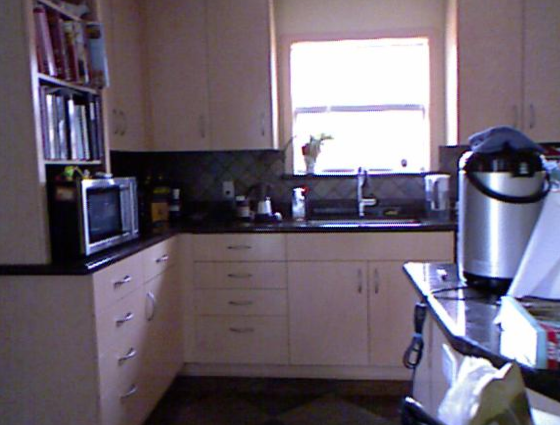

Question: what is in front of the window
Answer: ornamental_plant


In [3]:
# Preview some Image/Question/Answer combinations

def preview_sample(train=True, id=None):
    if train:
        data = dataset["train"]
    else:
        data = dataset["test"]
    if id == None:
        id = np.random.randint(len(data))
    
    image = Image.open(os.path.join("..", "data", "images", data[id]["image_id"] + ".png"))
    display(image)

    print("Question:", data[id]["question"])
    print("Answer:", data[id]["answer"])

preview_sample()